# Logistic and linear regression with deterministic and stochastic first order methods

    Lab 2 : Optimisation - DataScience Master
    Authors : Robert Gower, Alexandre Gramfort, Pierre Ablin, Mathurin Massias
   
The aim of this lab is to implement and compare various batch and stochastic algorithms for linear and logistic regression with ridge penalization. 

The following methods are compared in this notebook.

**Batch (deterministic) methods**

- gradient descent (GD)
- accelerated gradient descent (AGD)
- L-BFGS
- conjugate gradient (CG)

**Stochastic algorithms**

- stochastic gradient descent (SGD)
- stochastic averaged gradient (SAG)
- stochastic variance reduced gradient (SVRG)

Note that we consider as use-cases logistic and linear regression with ridge penalization only, although most of the algorithms below can be used with many other models, and other types of penalization, eventually non-smooth ones, such as the $\ell_1$ penalization.


## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work **before the 26th of november at 23:55**, using the **moodle platform**.
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "salma"
ln1 = "jeridi"
fn2 = "aymen"
ln2 = "dabghi"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["lab2", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab2_jeridi_salma_and_dabghi_aymen.ipynb


# Gentle reminder: no evaluation if you don't respect this EXACTLY

### Table of content

[1. Loss functions, gradients and step-sizes](#loss)<br>
[2. Generate a dataset](#data)<br>
[3. Deterministic methods](#batch)<br>
[4. Stochastic methods](#stoc)<br>
[5. Numerical comparison](#comp)<br>
[6. Conclusion](#conc)<br>

In [2]:
%matplotlib inline

In [3]:
from time import time

import numpy as np
from scipy.linalg import norm
import matplotlib.pyplot as plt
from numba import njit

In [4]:
# choose a large font size by default and use tex for math
usetex = False # change this to True if you have a working LaTeX install

fontsize = 16
params = {'axes.labelsize': fontsize + 2,
      'font.size': fontsize + 2,
      'legend.fontsize': fontsize-2 ,
      'xtick.labelsize': fontsize,
      'ytick.labelsize': fontsize,
      'text.usetex': usetex}
plt.rcParams.update(params)

<a id='loss'></a>
## 1. Loss functions, gradients and step-sizes


We want to minimize
$$
\frac 1n \sum_{i=1}^n \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2
$$
where
- $\ell(z, b) = \frac 12 (b - z)^2$ (least-squares regression)
- $\ell(z, b) = \log(1 + \exp(-bz))$ (logistic regression).

We write it as a minimization problem of the form
$$
\frac 1n \sum_{i=1}^n f_i(x)
$$
where
$$
f_i(x) = \ell(a_i^\top x, b_i) + \frac \lambda 2 \|x\|_2^2.
$$

For both cases, the gradients are
$$
\nabla f_i(x) = (a_i^\top x - b_i) a_i + \lambda x
$$
and
$$
\nabla f_i(x) = - \frac{b_i}{1 + \exp(b_i a_i^\top x)} a_i + \lambda x.
$$

Denote by $L$ (resp. $L_i$) the Lipschitz constant of $f$ (resp. $f_i$) and $\mathbf A^\top = [a_1, \ldots, a_n].$
One can easily see (using $\|\cdot\|_{2}$ for the matrix spectrale norm) that for linear regression
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{n} + \lambda \quad \text{ and } L_i = \| a_i \|_2^2 + \lambda
$$
while for logistic regression it is
$$
L = \frac{ \|\mathbf A^\top \mathbf A \|_{2}}{4 n} + \lambda \quad \text{ and } L_i = \frac 14 \| a_i \|_2^2 + \lambda.
$$
For full-gradient methods, the theoretical step-size is $1 / L$, while for SAG and SVRG (see below) it can be taken as
$1 / (\max_{i=1,\ldots,n} L_i)$

We now introduce functions that will be used for the solvers.


In [5]:
@njit    
def grad_i_linreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    return (a_i.dot(x) - b[i]) * a_i + lbda * x


@njit
def grad_linreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_linreg(i, x, A, b, lbda)
    return g / n


def loss_linreg(x, A, b, lbda):
    return norm(A.dot(x) - b) ** 2 / (2. * n) + lbda * norm(x) ** 2 / 2.


def lipschitz_linreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / n + lbda

In [6]:
@njit    
def grad_i_logreg(i, x, A, b, lbda):
    """Gradient with respect to a sample"""
    a_i = A[i]
    b_i = b[i]
    return - a_i * b_i / (1. + np.exp(b_i * np.dot(a_i, x))) + lbda * x


@njit
def grad_logreg(x, A, b, lbda):
    """Full gradient"""
    g = np.zeros_like(x)
    for i in range(n):
        g += grad_i_logreg(i, x, A, b, lbda)
    return g / n


def loss_logreg(x, A, b, lbda):
    bAx = b * np.dot(A, x)
    return np.mean(np.log(1. + np.exp(- bAx))) + lbda * norm(x) ** 2 / 2.


def lipschitz_logreg(A, b, lbda):
    return norm(A, ord=2) ** 2 / (4. * n) + lbda

<a id='data'></a>
## 2. Generate a dataset

We generate datasets for the least-squares and the logistic cases. First we define a function for the least-squares case.

In [7]:
from numpy.random import multivariate_normal, randn
from scipy.linalg.special_matrices import toeplitz


def simu_linreg(x, n, std=1., corr=0.5):
    """Simulation for the least-squares problem.

    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """
    d = x.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    A = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    b = A.dot(x) + noise
    return A, b

In [8]:
def simu_logreg(x, n, std=1., corr=0.5):
    """Simulation for the logistic regression problem.
    
    Parameters
    ----------
    x : ndarray, shape (d,)
        The coefficients of the model
    n : int
        Sample size    
    std : float, default=1.
        Standard-deviation of the noise
    corr : float, default=0.5
        Correlation of the features matrix
    
    Returns
    -------
    A : ndarray, shape (n, d)
        The design matrix.
    b : ndarray, shape (n,)
        The targets.
    """    
    A, b = simu_linreg(x, n, std=1., corr=corr)
    return A, np.sign(b)

In [9]:
d = 50
n = 10000
idx = np.arange(d)

# Ground truth coefficients of the model
x_model_truth = (-1)**idx * np.exp(-idx / 10.)

_A, _b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
#_A, _b = simu_logreg(x_model_truth, n, std=1., corr=0.7)

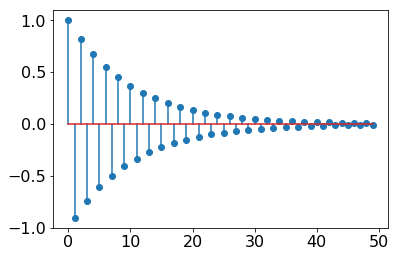

In [10]:
plt.stem(x_model_truth);

### Numerically check loss and gradient


In [10]:
from scipy.optimize import check_grad

lbda = 1. / n ** (0.5)

A, b = simu_linreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_linreg, grad_linreg, np.random.randn(d), A, b, lbda)

2.294087347153433e-06

In [11]:
lbda = 1. / n ** (0.5)

A, b = simu_logreg(x_model_truth, n, std=1., corr=0.1)
# Check that the gradient and the loss numerically match
check_grad(loss_logreg, grad_logreg, np.random.randn(d), A, b, lbda)

1.5180430131866542e-07

### Choice of the model
$\rightarrow$ During the first part, we will work with linear regression under high correlation ($corr=0.9$) and high regularization ($\lambda = \frac{1}{\sqrt n}  $ )

In [27]:
A, b = simu_linreg(x_model_truth, n, std=1., corr=0.9)
loss = loss_linreg
grad = grad_linreg
grad_i = grad_i_linreg
lipschitz_constant = lipschitz_linreg
lbda = 1. / n ** (0.5)

### Compute the theoretical step-size for gradient descent

In [28]:
step = 1. / lipschitz_constant(A, b, lbda)

print("step = %s" % step)

step = 0.06307849162362988


### Get a very precise minimum to compute distances to minimum

In [29]:
from scipy.optimize import fmin_l_bfgs_b

x_init = np.zeros(d)
x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)


print(f_min)
print(norm(grad_linreg(x_min, A, b, lbda)))

0.518816566637659
2.8940289503423192e-08


<a id='batch'></a> 

## 3. Deterministic/Batch methods (GD, AGD, BFGS)

### Define a class to monitor iterations

In [30]:
class monitor:
    def __init__(self, algo, loss, x_min, args=()):
        self.x_min = x_min
        self.algo = algo
        self.loss = loss
        self.args = args
        self.f_min = loss(x_min, *args)
    
    def run(self, *algo_args, **algo_kwargs):
        t0 = time()
        _, x_list = self.algo(*algo_args, **algo_kwargs)
        self.total_time = time() - t0
        self.x_list = x_list
        self.err = [norm(x - self.x_min) for x in x_list]
        self.obj = [self.loss(x, *self.args) - self.f_min for x in x_list]

In [31]:
# Number of iterations
n_iter = 50

### Gradient descent (GD)

We recall that an iteration of batch gradient writes

$$
x_{k+1} \gets x_k - \eta \nabla f(x_k)
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the GD solver in the cell below

In [32]:
@njit
def gd(x_init, grad, n_iter=100, step=1., store_every=1, args=()):
    """Gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for i in range(n_iter):
        ### TODO
        x_new = x- step* grad(x, *args)
        x=x_new
        ### END TODO
        if i % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [33]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_gd = monitor(gd, loss, x_min, (A, b ,lbda))
monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### Accelerated Gradient Descent (AGD)

We recall that an iteration of AGD (see FISTA) writes:

$$
\begin{align*}
x_{k+1} &\gets y_k - \eta \nabla f(y_k) \\
t_{k+1} &\gets \frac{1 + \sqrt{1 + 4 t_k^2}}{2} \\
y_{k+1} &\gets x_{k+1} + \frac{t_k-1}{t_{k+1}} (x_{k+1} - x_k)
\end{align*}
$$

where $\eta$ is the step-size (that can be chosen in theory as $\eta = 1 / L$, with $L$ the Lipshitz constant of $\nabla f$, see above)

*QUESTION*:
- Fill in the iteration of the AGD solver in the cell below

In [34]:
@njit
def agd(x_init, grad, n_iter=100, step=1., args=(), store_every=1):
    """Accelerated Gradient Descent algorithm."""
    x = x_init.copy()
    y = x_init.copy()
    t = 1.
    x_list = []
    for i in range(n_iter):
        
        x_aux = x
        x = y - step*grad(y,*args)
        t_aux = t
        t = (1 + np.sqrt(1 + 4*t_aux**2))/2
        y = x + ((t_aux - 1)/t) * (x - x_aux)
        
        if i % store_every == 0:
            x_list.append(x.copy())
       
    return x, x_list

In [35]:
step = 1. / lipschitz_linreg(A, b, lbda)
x_init = np.zeros(d)
monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

### scipy.optimize's conjuguate gradient

Let's compare with ``scipy.optimize``'s nonlinear conjuguate gradient solver. First, define a function to run scipy algorithms and return the list of iterates.

In [36]:
class callback():
    def __init__(self):
        self.x_list = []
    
    def __call__(self, x):
        self.x_list.append(x.copy())
        
        
def scipy_runner(scipy_algo):
    def run(*args, **kwargs):
        cb = callback()
        x = scipy_algo(*args, **kwargs, callback=cb)
        return x, cb.x_list
    return run

In [37]:
# Nonlinear Conjugate gradient algorithm
from scipy.optimize import fmin_cg

x_init = np.zeros(d)

monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

         Current function value: 0.518846
         Iterations: 50
         Function evaluations: 85
         Gradient evaluations: 85


### scipy.optimize's L-BFGS

Let's compare with ``scipy.optimize``'s L-BFGS solver

In [38]:
# L-BFGS algorithm
from scipy.optimize import fmin_l_bfgs_b


x_init = np.zeros(d)

monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

### A first numerical comparison of deterministic solvers

First, define some plotting functions.

In [39]:
def plot_epochs(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        plt.semilogy(monit.obj, lw=2)
        plt.title("Loss")
        plt.xlabel("Epoch")
        plt.ylabel("objective")

    plt.legend(solvers)

    plt.subplot(1, 2, 2)

    for monit in monitors:
        plt.semilogy(monit.err, lw=2)
        plt.title("Distance to optimum")
        plt.xlabel("Epoch")
        plt.ylabel("$\|x_k - x^*\|_2$")

    plt.legend(solvers)
    

def plot_time(monitors, solvers):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    for monit in monitors:
        objs = monit.obj
        plt.semilogy(np.linspace(0, monit.total_time, len(objs)), objs, lw=2)
        plt.title("Loss")
        plt.xlabel("Timing")
        plt.ylabel("$f(x_k) - f(x^*)$")

    plt.legend(solvers)

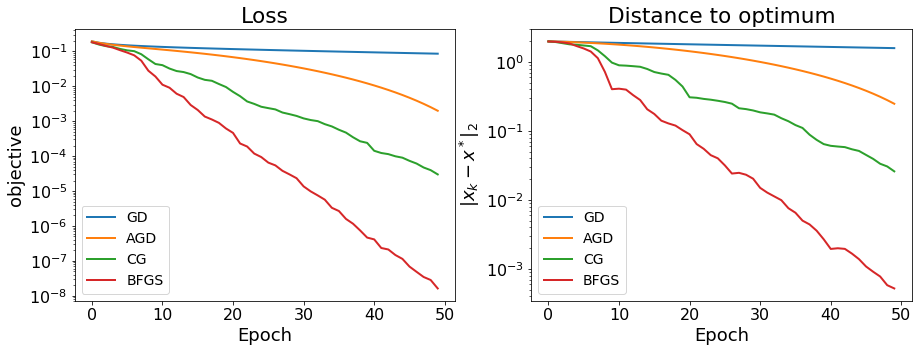

In [40]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs]

solvers = ["GD", "AGD", "CG", "BFGS"]

plot_epochs(monitors, solvers)

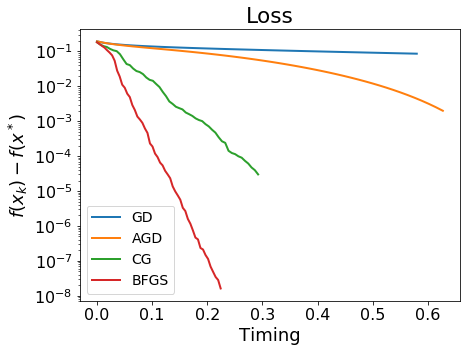

In [41]:
plot_time(monitors, solvers)

### First conclusions

*QUESTIONS*:

- Give some first conclusions about the batch solver studied here
- What do you observe about AGD? is it suprising ?

<div class="alert alert-info" >
<h3>Answers :</h3>  

<strong>In terms of performance:</strong>  



$\bullet$ We notice that Scipy Optimizers (CG & BFGS) outperform GD & AGD. In fact, the CG algorithm reaches a minimum of the order of $10^{-15}$ in 50 iterations and a distance to the minimum of the order of $10^{-7}$ while the minimum given by AGD doesn't exceed $10^{-6}$ and its distance to the true minimum doesn't exceed $10^{-2}$.  


$\bullet$ Now if we want to compare CG and BFGS, we can notice that they give back almost the same results despite the fact that BFGS sometimes doesn't complete its 50 iterations due to stop condition given above.   


$\bullet$ As for the GD & AGD, we can notice that AGD outperforms GD reaching a minimum of the order of $10^{-5}$ while the value returned by GD doesn't exceed $10^{-2}$.  

<br>
<strong>In terms of speed:</strong>  


$\bullet$ We can say that the same observations we gave above can be applied here. In fact, we can sort our 4 algorithms as follows : BFGS a bit faster than CG who is way faster than GD, while AGD is the slowest among them.  

<br>
<strong>AGD behaviour:</strong>  

$\bullet$ In order to see more clearly the behaviour of thr AGD algorithm, all we have to do is : either increase the number pf iterations, or decrease the correlation value. Here we choose to reduce the correlation and you can find below the result of the plot.   
$\rightarrow$ We can observe that AGD presents some bounds during its convergence and it is not surprising, these bounds are due to the fact that AGD (or FISTA), as we saw in the first lab, is not a descent algorithm,it has weighted memory about the past at each step and does not always go along the  optimal direction. 
</div>

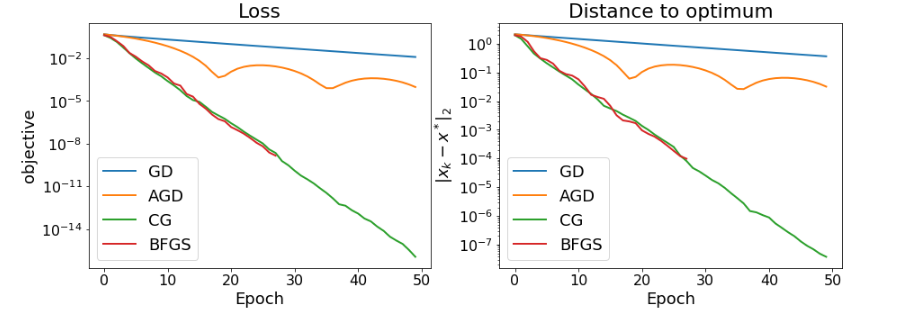

In [1]:
#### Do not run this cell !!!  ####
# Linear regression with corr = 0.7
from PIL import Image
Image.open("/home/salma/Bureau/Master/optim/Lin_reg_corr=0.7.png")

<a id='stoc'></a> 
## 4. Stochastic methods

In [42]:
n_iter = 50

# generate indices of random samples
iis = np.random.randint(0, n, n * n_iter)

### SGD

We recall that an iteration of SGD writes

- Pick $i$ uniformly at random in $\{1, \ldots, n\}$
- Apply
$$
x_{t+1} \gets x_t - \frac{\eta_0}{\sqrt{t+1}} \nabla f_i(x_t)
$$

where $\eta_0$ is a step-size to be tuned by hand.

*QUESTION*:
- Fill in the iteration of the SGD solver in the cell below

In [43]:
@njit
def sgd(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic gradient descent algorithm."""
    x = x_init.copy()
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
        x= x- (step/np.sqrt(idx+1))* grad_i(i, x, *args)
        ### END TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [44]:
step0 = 1e-1
x_init = np.zeros(d)

monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
monitor_sgd.run(x_init, iis, grad_i, n_iter*n , step0, args=(A, b, lbda))

### SAG

We recall that an iteration of SAG writes

For $t=1, \ldots, $ until convergence

1. Pick $i_t$ uniformly at random in $\{1, \ldots, n\}$

2. Update the average of gradients
$$
G_t \gets \frac 1n \sum_{i=1}^n g_i^t
$$
where 
$$
g_i^t =
\begin{cases}
    \nabla f_{i}(x_t) &\text{ if } i = i_t \\
    g_i^{t-1} & \text{ otherwise.}
\end{cases}
$$

3. Apply the step 
$$x_{t+1} \gets x_t - \eta G_t$$
where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SAG solver in the cell below

In [45]:
a=np.array([1 ,0])
0.5-a

array([-0.5,  0.5])

In [46]:
@njit
def sag(x_init, iis, grad_i, n_iter=100, step=1., store_every=n, args=()):
    """Stochastic average gradient algorithm."""
    x = x_init.copy()
    # Old gradients
    gradient_memory = np.zeros((n, d))
    averaged_gradient = np.zeros(d)
    x_list = []
    for idx in range(n_iter):
        i = iis[idx]
        
        ### TODO
       
        aux = grad_i(i, x,*args)
        averaged_gradient = averaged_gradient + (1./n)*(aux - gradient_memory[i, :]) 
        gradient_memory[i, :] = aux
        x = x - step*averaged_gradient
        ### END OF TODO
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [47]:
max_squared_sum = np.max(np.sum(A ** 2, axis=1))
step = 1.0 / (max_squared_sum + lbda)

x_init = np.zeros(d)
monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
monitor_sag.run(x_init, iis, grad_i, n_iter *n, step, args=(A, b, lbda))

### SVRG

We recall that an iteration of SVRG writes

For $k=1, \ldots, $ until convergence

1. Set $\tilde x \gets \tilde x^{(k)}$ and $x_1^{(k)} \gets \tilde x$
2. Compute $\mu_k \gets \nabla f(\tilde x)$
3. For $t=1, \ldots, n$
    4. Pick $i$ uniformly at random in $\{1, \ldots, n\}$
    5. Apply the step 
$$
x_{t+1}^{(k)} \gets x_t^{(k)} - \eta \big(\nabla f_{i}(x_t^{(k)}) - \nabla f_{i}(\tilde x) + \mu_k \big) 
$$

6. Set $\tilde x^{(k+1)} \gets x_{n+1}^{(k)}$

where $\eta$ is the step-size (see code below).

*QUESTION*:
- Fill in the iteration of the SVRG solver in the cell below

In [48]:
@njit
def svrg(x_init, iis, grad, grad_i, n_iter=100, step=1., store_every=1, args=()):
    """Stochastic variance reduction gradient algorithm."""
    x = x_init.copy()
    x_list = []
    x_tilde=x.copy()
    for idx in range(n_iter):
        grad_tilde= grad(x_tilde,*args)
        x=x_tilde.copy()
        for k in range(n):
            i=iis[k]
            g= grad_i(i,x,*args)-grad_i(i,x_tilde,*args)+grad_tilde
            x= x- step* g
        x_tilde= x.copy()
        x=x_tilde 
        
        # Update metrics after each iteration.
        if idx % store_every == 0:
            x_list.append(x.copy())
    return x, x_list

In [49]:
x_init = np.zeros(d)
monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
monitor_svrg.run(x_init, iis, grad, grad_i, n_iter , step, args=(A, b, lbda))

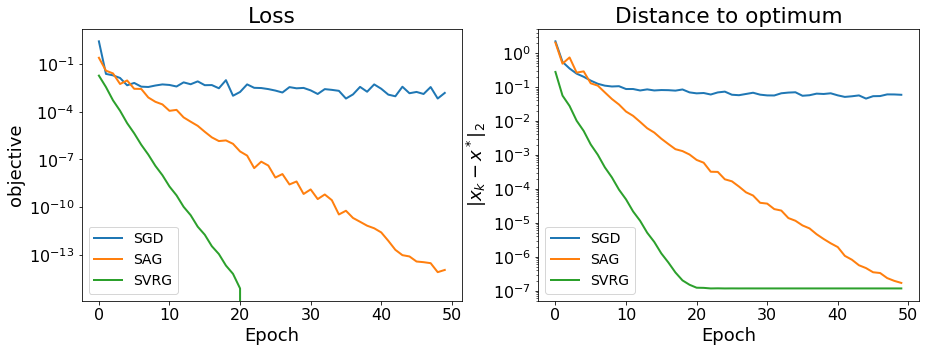

In [50]:
monitors = [monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

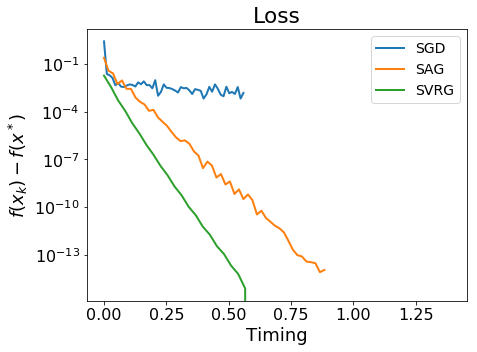

In [51]:
plot_time(monitors, solvers)

<a id='comp'></a> 
## 5. Numerical comparison

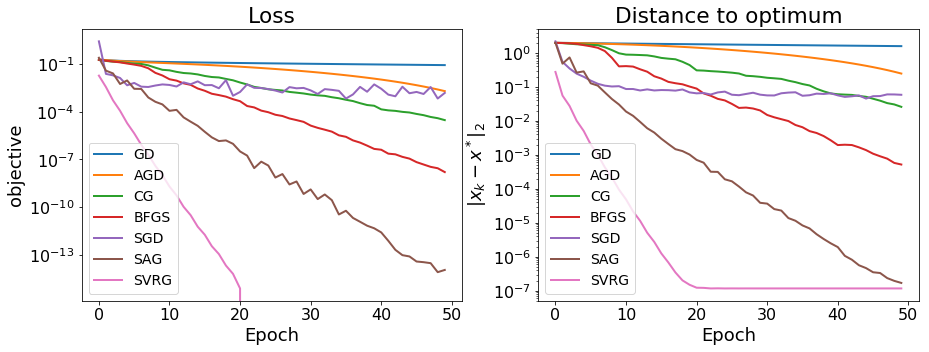

In [52]:
monitors = [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]

solvers = ["GD", "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]

plot_epochs(monitors, solvers)

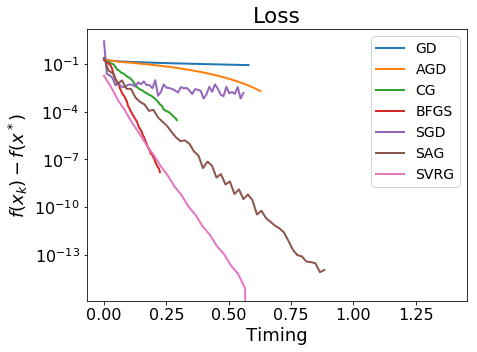

In [54]:
plot_time(monitors, solvers)

<a id='conc'></a>
## 6. Conclusion

*QUESTIONS*:
- 1) Compare and comment your results
- 2) Change the value of the ridge regularization (the ``lbda`` parameter) to low ridge $\lambda = 1 / n$ and high ridge regularization $\lambda = 1 / \sqrt n$ and compare your results. Comment.
- 3) Play also with the level of correlation between features (parameter ``corr`` above), and compare results with low and high correlation.
- 4) Conclude

<div class="alert alert-info" >

<strong>1) Compare and comment your results </strong>   
<br>

- We start by comparing the deterministic methods seen before with the stochastic algorithms, we can notice that, for a given correlation value equal to 0.9, all three of the stochastic algorithms outperform the batch methods for the first 10 iterations, but after that, the SGD algorithm converges to a value far from the minimum.   
  <br>
- SGD : While SAG & SVRG have linear convergence, SGD has a warm start then tends to have a flat curve that keeps swinging around the minimum. This is due to the fact that the gradient is noisy and the step size is not small enough which is causing a "ping pong effect" around the optimum. This problem with SGD can be overcame by reducing the step size, which will cause a slower convergence but a better value of the minimum.    

<br>

- SAG : Although the algorithm is faster than SGD but still, after 50 iterations, it does not converge. We can notice the fluctuations on the curve due to the variance but it is clear that it is reaching (in a few iterations) a better value of the minimum than SGD. In terms of speed, we can affirm that the SAG algorithm is almost as fast as CG.  
  <br>


- SVRG : For a fixed value of the correlation, the SVRG outperforms every other method in terms of performance and speed. It converges after only 20 iterations to the best value of the minimum among the other algorithms.


</div>

In [55]:
# To avoid repeating the code every time we change a parameter, here we are going to define a function 
    # that generates monitors according to 3 args: Correlation, lbda, and the name of the loss function.  

def monitor_func(lbda , corr=0.9, loss_name='linreg'): 
    if loss_name== 'linreg': 
        #We initialize the model 
        A, b = simu_linreg(x_model_truth, n, std=1., corr=corr)
        loss = loss_linreg
        grad = grad_linreg
        grad_i = grad_i_linreg
        lipschitz_constant = lipschitz_linreg
    elif loss_name=='logreg': 
        #We initialize the model 
        A, b = simu_logreg(x_model_truth, n, std=1., corr=corr)
        loss = loss_logreg
        grad = grad_logreg
        grad_i = grad_i_logreg
        lipschitz_constant = lipschitz_logreg
    else: 
        return print("Loss function not recognized, try <logreg> or <linreg>")
    lbda= lbda
    
    # Get a very precise minimum related to the new data
    x_init = np.zeros(d)
    x_min, f_min, _ = fmin_l_bfgs_b(loss, x_init, grad, args=(A, b, lbda), pgtol=1e-30, factr=1e-30)
    
    # Deterministic and stochastic methods: 
    
    ### GD
    step = 1. / lipschitz_constant(A, b, lbda)
    monitor_gd= monitor(gd, loss, x_min, (A, b ,lbda))
    monitor_gd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    ## AGD
    step = 1. / lipschitz_constant(A, b, lbda)
    x_init = np.zeros(d)
    monitor_agd = monitor(agd, loss, x_min, (A, b ,lbda))
    monitor_agd.run(x_init, grad, n_iter, step, args=(A, b, lbda))

    # Nonlinear Conjugate gradient algorithm
    x_init = np.zeros(d)
    monitor_cg = monitor(scipy_runner(fmin_cg), loss, x_min, (A, b ,lbda))
    monitor_cg.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), gtol=1e-9)

    ## BFGS
    x_init = np.zeros(d)
    monitor_bfgs = monitor(scipy_runner(fmin_l_bfgs_b), loss, x_min, (A, b ,lbda))
    monitor_bfgs.run(loss, x_init, grad, maxiter=n_iter, args=(A, b, lbda), pgtol=1e-30)

    ### SGD
    step0 = 1e-1
    x_init = np.zeros(d)
    monitor_sgd = monitor(sgd, loss, x_min, (A, b ,lbda))
    monitor_sgd.run(x_init, iis, grad_i, n_iter*n , step0, args=(A, b, lbda))

    #### SAG
    max_squared_sum = np.max(np.sum(A ** 2, axis=1))
    step = 1.0 / (max_squared_sum + lbda)
    monitor_sag = monitor(sag, loss, x_min, (A, b ,lbda))
    monitor_sag.run(x_init, iis, grad_i, n_iter *n, step, args=(A, b, lbda))

    ##### SVRG
    x_init = np.zeros(d)
    monitor_svrg = monitor(svrg, loss, x_min, (A, b ,lbda))
    monitor_svrg.run(x_init, iis, grad, grad_i, n_iter , step, args=(A, b, lbda))
   
    ### monitors list 
    monitors= [monitor_gd, monitor_agd, monitor_cg, monitor_bfgs,
            monitor_sgd, monitor_sag, monitor_svrg]
    return monitors


## 2) Change the value of the ridge regularization 
### Linear regression with low ridge $( \lambda = \frac{1}{n}) $ under the same correlation $(corr=0.9)$

         Current function value: 0.506293
         Iterations: 50
         Function evaluations: 80
         Gradient evaluations: 80


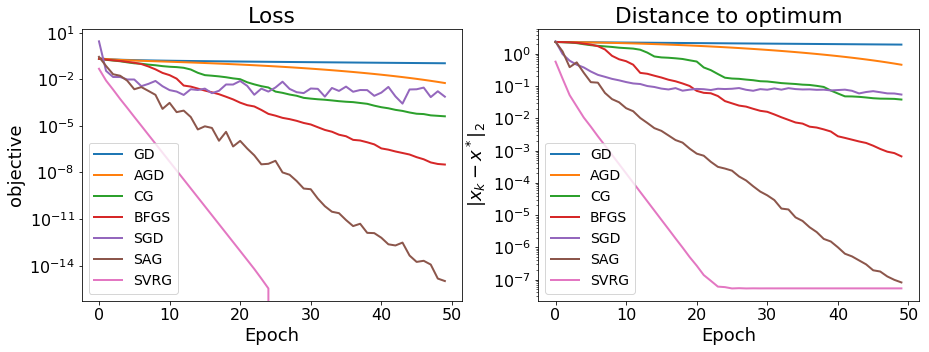

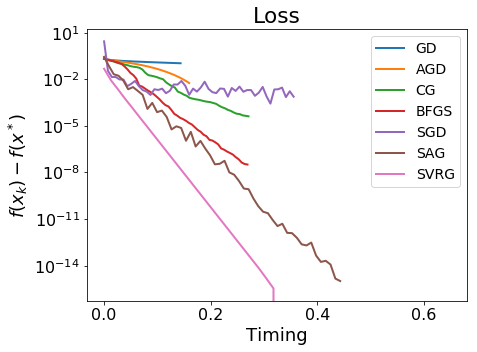

In [56]:
monitors = monitor_func(lbda=1./n, corr=0.9, loss_name='linreg')
plot_epochs(monitors , solvers)
plot_time(monitors, solvers)

<div class="alert alert-info" role="alert">
<strong> Comments :  </strong>
 <br>
<strong>- For linear regression :  </strong>
<br>
We notice that no significant change has been made between the 2 values $\frac{1}{\sqrt n}$ and $\frac{1}{n}$ of the rigde regularization in terms of loss and distance to the optimum. However, if we compare the loss in timing, we can notice that the stochastic algorithms have a lower execution time (2 times lower) when reducing the ridge regularization parameter. For example, the SVRG algorithm goes approximately from 0.6 to 0.3 .    
   $\Longrightarrow$ As we already know, the parameter $\lambda$ indicates the level of strong convexity of the objective, and since the convergence of some algorithms (SVRG, SGD ..) are negatively correlated with the level of strong convexity, then the higher the $\lambda$ is, the slower these algorithms are.
   
</div>

### Logistic regression with high ridge $( \lambda = \frac{1}{\sqrt n}) $ under high correlation $(corr=0.7)$

         Current function value: 0.525294
         Iterations: 50
         Function evaluations: 98
         Gradient evaluations: 98


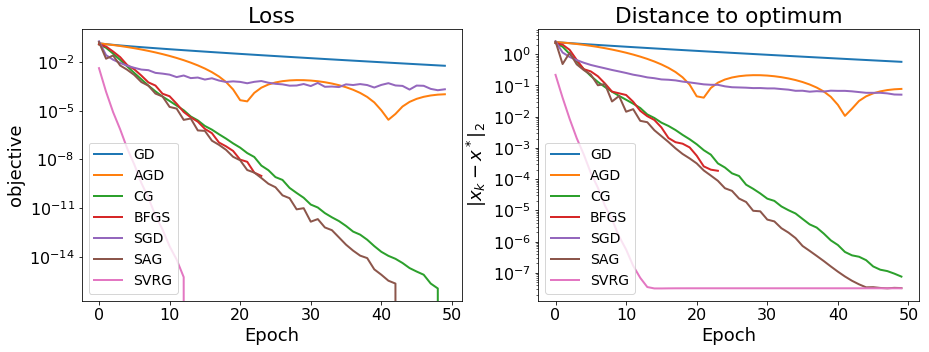

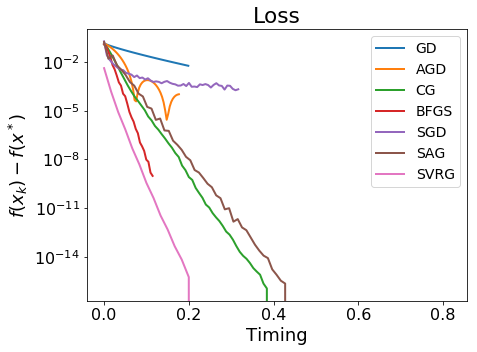

In [73]:
monitors = monitor_func(lbda=1./(n**0.5),corr=0.7,loss_name='logreg')
plot_epochs(monitors, solvers)
plot_time(monitors, solvers)

### Logistic regression with low ridge$( \lambda = \frac{1}{ n}) $ under the same high correlation $(corr=0.7)$

         Current function value: 0.465087
         Iterations: 50
         Function evaluations: 101
         Gradient evaluations: 101


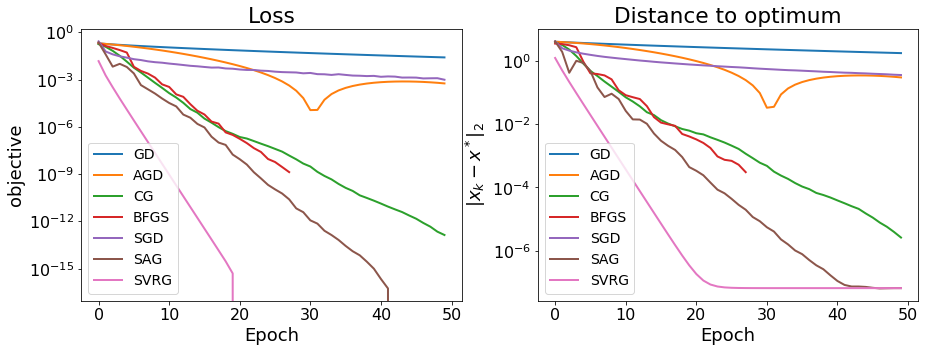

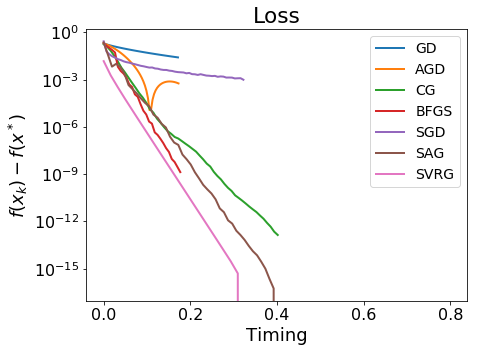

In [74]:
monitors = monitor_func(lbda=1./n,corr=0.7,loss_name='logreg')
plot_epochs(monitors, solvers)
plot_time(monitors, solvers)

<div class="alert alert-info" >
<strong>  Comments  </strong>  

<strong>  - For logistic regression :  </strong>  

   We notice that, under low ridge regularization value, SVRG is more time consuming than under a higher value.   
   In terms of convergence performance, we can see that stochastic algorithms are not affected by the choice of $\lambda$, they converge to the same optimum in both cases. But, if we talk about the number of iterations, we can clearly see that SVRG takes more iterations to converge with low regularization value.    
   As for the batch algorithms, AGD and CG are the ones affected by the change of $\lambda$. In fact, the bounds of the AGD get larger when reducing $\lambda$ and therefore the algorithm takes more time to go from one minimum to another. While CG behaves like stochastic algorithms with high $\lambda$ and performs worse when reducing the regularization.     
   $\Longrightarrow$ Generally, under low ridge condition, the algorithm should pass through more coefficients to get the minimum loss, which explains the behaviour of the AGD and CG (batch algorithms in general).


</div>

## 3) Change the correlation level under high ridge $(\lambda= \frac {1}{\sqrt n})$
### Linear regression with corr = [0.3, 0.6, 0.9] 

Optimization terminated successfully.
         Current function value: 0.491932
         Iterations: 24
         Function evaluations: 34
         Gradient evaluations: 34
         Current function value: 0.503766
         Iterations: 42
         Function evaluations: 73
         Gradient evaluations: 72
         Current function value: 0.497119
         Iterations: 50
         Function evaluations: 76
         Gradient evaluations: 76


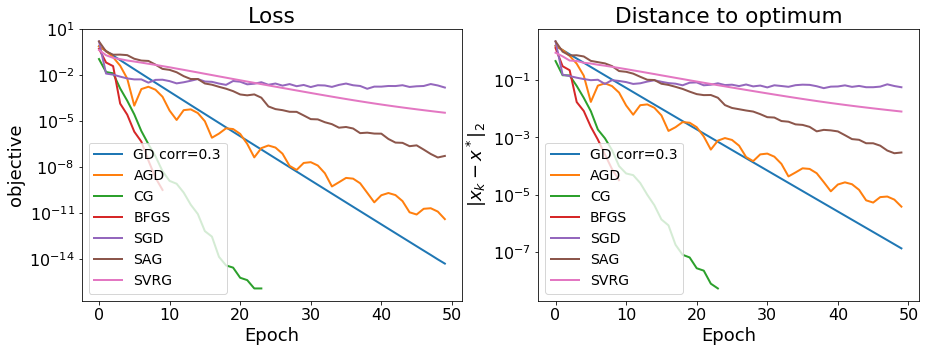

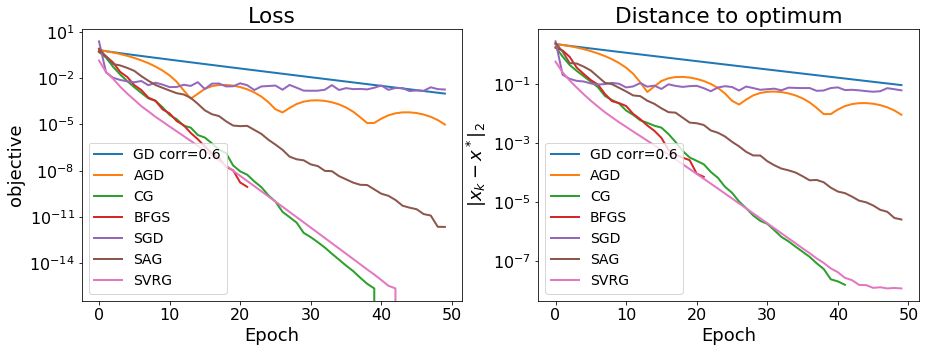

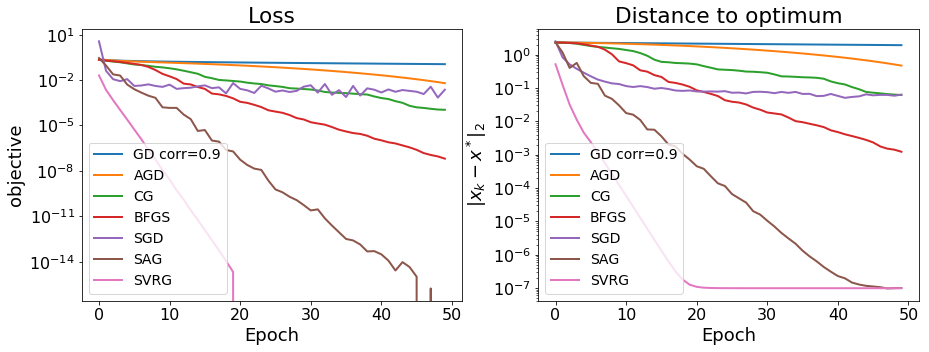

In [135]:

corr = [0.3, 0.6, 0.9]
monitors=[]
for i in range(3): 
    monitors.append( monitor_func(lbda=1./n**5,corr=corr[i], loss_name='linreg'))
    solvers = ["GD corr="+str(corr[i]), "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
    plot_epochs(monitors[i], solvers)


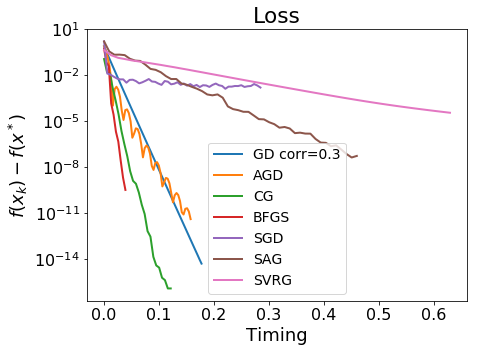

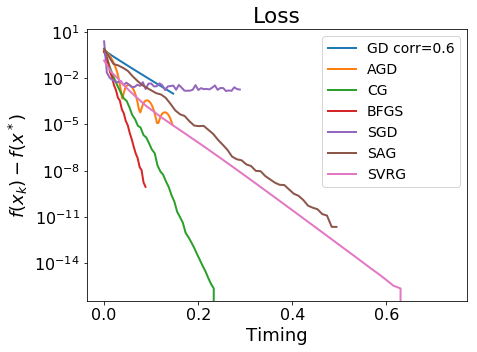

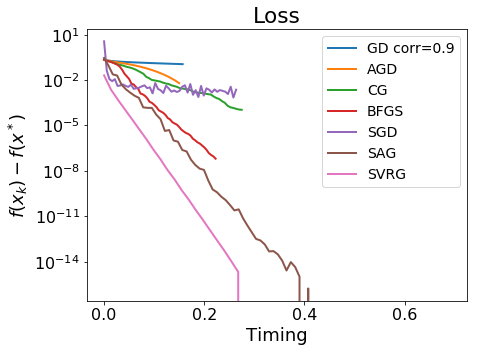

In [136]:
for i in range(3): 
   
    solvers = ["GD corr="+str(corr[i]), "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
    plot_time(monitors[i], solvers)

### Logistic regression with corr = [0.3, 0.6, 0.9] 

Optimization terminated successfully.
         Current function value: 0.346992
         Iterations: 33
         Function evaluations: 95
         Gradient evaluations: 95
         Current function value: 0.441012
         Iterations: 50
         Function evaluations: 106
         Gradient evaluations: 106
         Current function value: 0.563821
         Iterations: 50
         Function evaluations: 73
         Gradient evaluations: 73


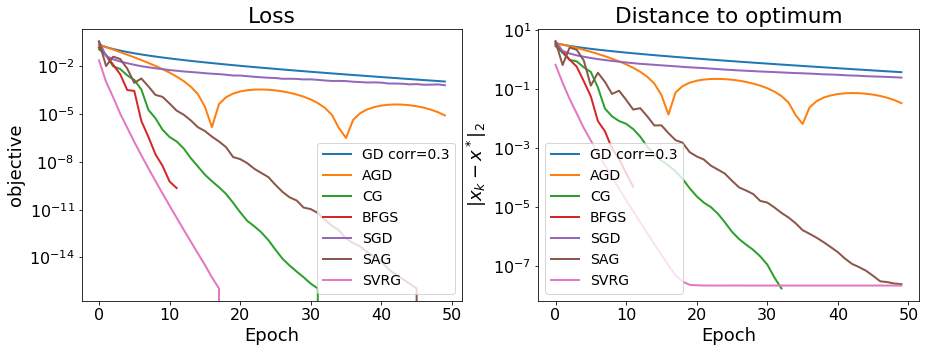

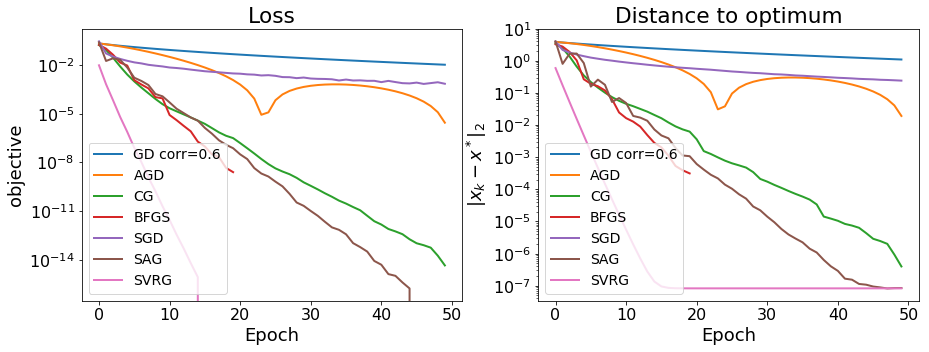

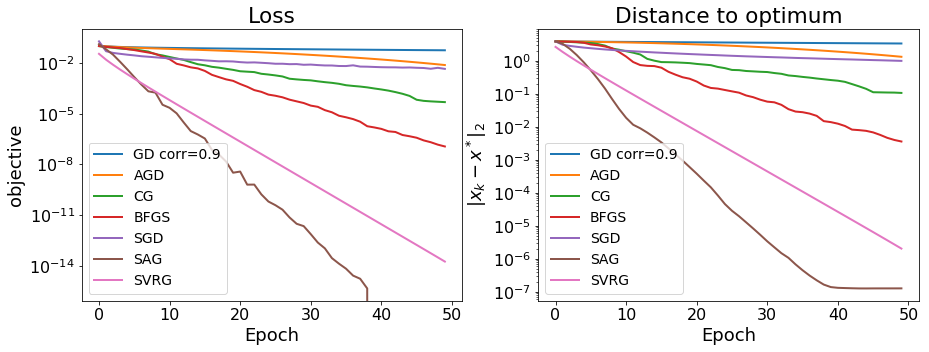

In [137]:
corr = [0.3, 0.6, 0.9]
monitors=[]
for i in range(3): 
    monitors.append( monitor_func(lbda=1./n**5,corr=corr[i], loss_name='logreg'))
    solvers = ["GD corr="+str(corr[i]), "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
    plot_epochs(monitors[i], solvers)


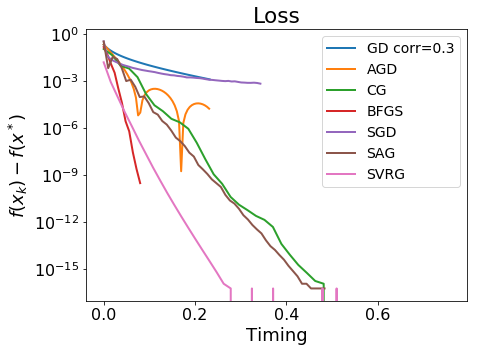

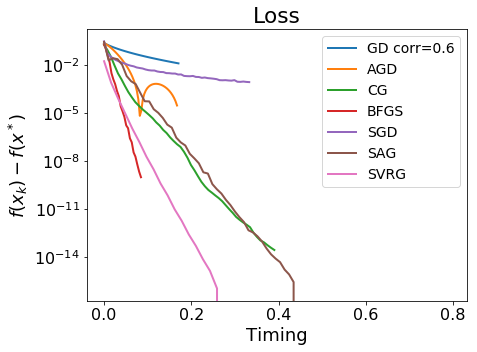

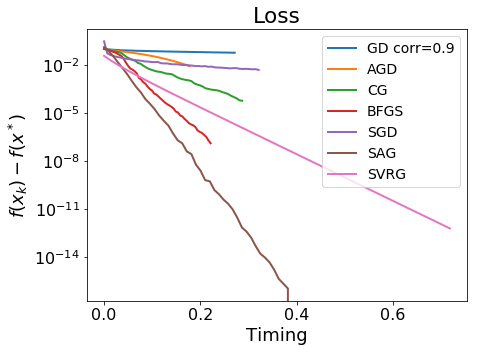

In [112]:
for i in range(3): 
   
    solvers = ["GD corr="+str(corr[i]), "AGD", "CG", "BFGS", "SGD", "SAG", "SVRG"]
    plot_time(monitors[i], solvers)

<div class="alert alert-info" role="alert">
 <strong> Comments :  </strong>  
 
  
      
      
 <strong>  - For linear regression :  </strong>   
  On the one hand, under low correlation, all batch algorithms perform better (than both stochastic algorithms and themselves in the high correlation case) in terms of loss, distance to the optimum and timing. So the higher the correlation is, the slower deterministic algorithms are, and the larger the bounds of AGD algorithm. On the other hand, we notice an opposite behaviour from stochastic algorithms; in fact, they perform way better under high correlation, except the SGD that is not affected by this change. For example, SVRG converges very fast under a correlation equal to 0.3 but reaches a point very far from the optimum and its curve becomes flat.   
  
  
 <strong>  - For logistic regression :   </strong>  
  For batch algorithms, we notice that they are still better with low correlation than a high one, but comparing to the linear case under low correlation, we notice that their performance is poorer (the minimum reached in the logistic regression is of the order of $10^{-6}$ while in the linear regression is of the order of $10^{-11}$).  
  As for stochastic algorithms, we observe, that for low values of the correlation, SVRG, SAG perform in an acceptable way, meaning they converge under the 50 iterations reaching a distance to optimum of the order of $10^{-7}$. But, unlike the linear case, stochastic algorithms get slower and give a bad result under high correlation (0.9). So, the compromise is to fix a medium value of the correlation (0.6) and thus, obtain a better and faster convergence.   
  
  
  $\Longrightarrow$ The behaviour of batch algorithms can be explained by the fact that both methods GD & AGD suffer from correlated features, which is consistent with the fact that their convergence rate is proportional to the Lipschitz constant of the gradient of $f$, which grows with the amount of correlation.   
  
  $\Longrightarrow$ We can say that, by implementation, both SVRG & SAG aim to reduce the variance of noisy gradients by introducing a new variable with known expectation that is positively correlated with the gradient. So highly correlated data will favor this operation. This is the reason why SVRG & SAG  performs better with high correlated data and can easily find a way to the minimum.
 
 </div>

<div class="alert alert-info" role="alert">
 <strong> 4) Conclusion :  </strong>   
 - The regularization level has a little effect on the minimums reached by all algorithms studied, but it affects the execution time.  
 - The choice of a suitable agorithm depends on the level of the correlation of the data.  
 - With highly correlated data, SVRG & SAG are recommended, while with low correlation, batch algorithms perform better.   
 - In terms of timing, SVRG & SAG are more time consuming due to the fact that at each iteration they have more computations to do and more results to store.  
 </div>